# CNN Model for MNISt

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
with tf.device('/GPU:0'):
# Train the model
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

c:\Users\adnan\anaconda3\envs\new\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"






Epoch 1/3


1875/1875 [==============================] - 23s 12ms/step - loss: 0.1624 - accuracy: 0.9523 - val_loss: 0.0565 - val_accuracy: 0.9816
Epoch 2/3
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.0492 - val_accuracy: 0.9833
Epoch 3/3
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.0417 - val_accuracy: 0.9859


In [2]:
import numpy as np
prediction=model.predict(x_test)
accuracy_orginal=np.mean(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy for the original data: ",accuracy_orginal*100)

313/313 [==============================] - 1s 3ms/step
Accuracy for the original data:  98.59


# Deep Fool Attack

In [3]:
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.optimizers import Adam

# Convert the Keras model to an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0, 1),
    optimizer=Adam(learning_rate=0.001) 
)

# Create the DeepFool attack
attack = DeepFool(classifier)

# Generate adversarial test examples
x_test_adv = attack.generate(x_test,y_test)


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
prediction_attack=model.predict(x_test_adv)
accuracy_attack=np.mean(np.argmax(prediction_attack, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy after aplying deepfool attack: ",accuracy_attack*100)

313/313 [==============================] - 1s 4ms/step
Accuracy after aplying deepfool attack:  3.7900000000000005


### Comparing Adversarial and Original

##

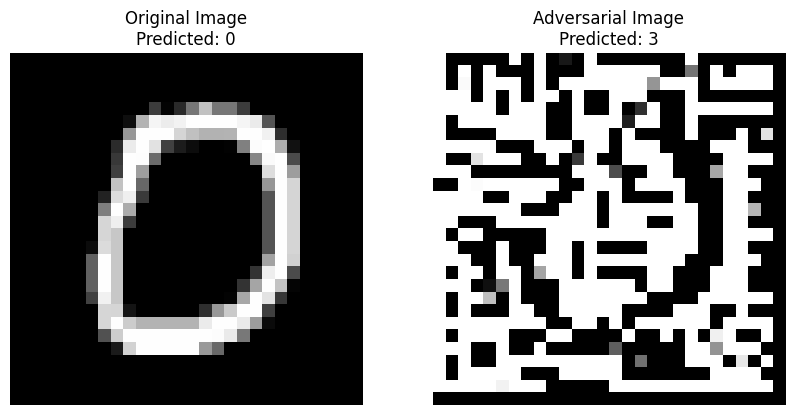

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Let's select the first image in the test set for comparison
original_image = x_test[10]
adversarial_image = x_test_adv[10]

# Predictions before the attack
original_pred = classifier.predict(np.array([original_image]))
# Predictions after the attack
adversarial_pred = classifier.predict(np.array([adversarial_image]))

# Reshape images for plotting
original_image = original_image.reshape(28, 28)
adversarial_image = adversarial_image.reshape(28, 28)

# Plot the original and adversarial images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title(f"Original Image\nPredicted: {np.argmax(original_pred)}")
plt.axis('off')

# Adversarial image
plt.subplot(1, 2, 2)
plt.imshow(adversarial_image, cmap='gray')
plt.title(f"Adversarial Image\nPredicted: {np.argmax(adversarial_pred)}")
plt.axis('off')

plt.show()


Text(0.5, 1.0, 'Comparing the accuracy befor the attack and after')

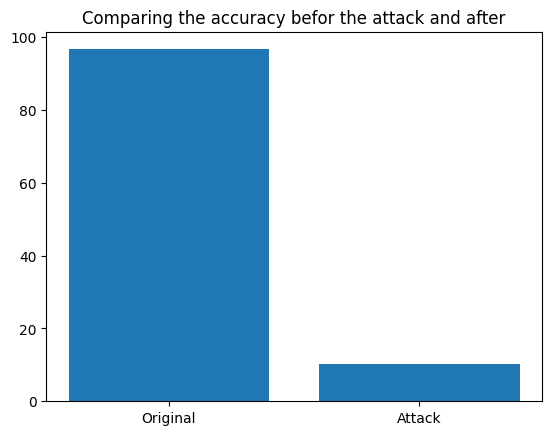

In [62]:
comparing_accuracy=[accuracy_orginal*100,accuracy_attack*100]
plt.bar(["Original","Attack"],comparing_accuracy)
plt.title("Comparing the accuracy befor the attack and after")

# Defenses

### Feature Squeezing

In [35]:
from art.defences.preprocessor import FeatureSqueezing

# Initialize feature squeezing
fs = FeatureSqueezing(clip_values=(0, 1), bit_depth=1)

# Apply feature squeezing to the adversarial examples
x_test_adv_squeezed, _ = fs(x_test_adv)

# Evaluate the model on the feature-squeezed adversarial examples
predictions = model.predict(x_test_adv_squeezed)
accuracy_feature = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy on feature-squeezed adversarial examples: {:.2%}".format(accuracy_feature))


313/313 [==============================] - 1s 3ms/step
Accuracy on feature-squeezed adversarial examples: 13.55%


### Thermometer Encoding

This defense discretizes the inputs into a number of levels which are then encoded using a thermometer-style code. It can sometimes obscure the gradients that the DeepFool attack relies on.

In [6]:
from art.defences.preprocessor import ThermometerEncoding
import numpy as np

# Initialize the Thermometer Encoding defense
thermometer_encoding = ThermometerEncoding(num_space=10, clip_values=(0, 1), apply_fit=True, apply_predict=False)

# Apply the defense to the training and test data
x_train_te, _ = thermometer_encoding(x_train)
x_test_te, _ = thermometer_encoding(x_test_adv)

# Reduce the encoded data back to the original number of channels
# For example, by taking the average across the thermometer-encoded channels
x_train_te_reduced = np.mean(x_train_te, axis=-1, keepdims=True)
x_test_te_reduced = np.mean(x_test_te, axis=-1, keepdims=True)

with tf.device('/GPU:0'):
# Train the model with the reduced thermometer-encoded data
    classifier.fit(x_train_te_reduced, y_train, nb_epochs=5, batch_size=64)


In [36]:
# Evaluate the model on the reduced thermometer-encoded test set
predictions = classifier.predict(x_test_te_reduced)
accuracy_thermometer = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy on reduced thermometer-encoded test examples: {:.2%}".format(accuracy_thermometer))

Accuracy on reduced thermometer-encoded test examples: 95.39%


### Total Variance Minimization

This technique applies a total variance minimization filter to smooth the input images. It can reduce the effectiveness of small perturbations introduced by attacks like DeepFool.

In [20]:
#Total Variance Minimization
from art.defences.preprocessor import TotalVarMin

# Initialize the Total Variance Minimization defense
total_var_min = TotalVarMin()

# Apply the defense to the test data
x_test_tvm, _ = total_var_min(x_test_adv)


In [40]:
# Evaluate the model on the total variance minimized test set
predictions = classifier.predict(x_test_tvm)
accuracy_variance = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy on total variance minimized test examples: {:.2%}".format(accuracy_variance))

Accuracy on total variance minimized test examples: 33.73%


### Gaussian Data Augmentation

By adding Gaussian noise to the training data, the model become more robust to the small changes introduced by DeepFool.

In [23]:
#Gaussian Data Augmentation
from art.defences.preprocessor import GaussianAugmentation

# Initialize the Gaussian Data Augmentation defense
gaussian_augmentation = GaussianAugmentation(sigma=1.0, augmentation=True)

# Apply the defense to generate augmented training data
x_train_ga, y_train_ga = gaussian_augmentation(x_train, y_train)

# Combine the original and augmented data
x_train_combined = np.concatenate((x_train, x_train_ga), axis=0)
y_train_combined = np.concatenate((y_train, y_train_ga), axis=0)

# Train the model with combined data
classifier.fit(x_train_combined, y_train_combined, nb_epochs=5, batch_size=64)



In [39]:
# Evaluate the model on the original test set
predictions = classifier.predict(x_test_adv)
accuracy_gaussian = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy on test examples after Gaussian Data Augmentation: {:.2%}".format(accuracy_gaussian))


Accuracy on test examples after Gaussian Data Augmentation: 96.69%


Text(0.5, 1.0, 'Accuracy after applying the defnses methods')

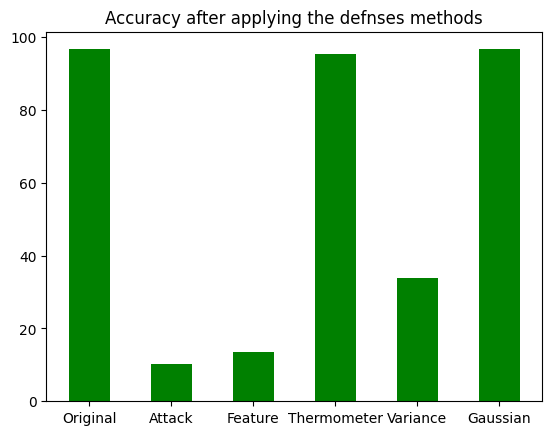

In [60]:
accuracylist=[accuracy_orginal*100,accuracy_attack*100,accuracy_feature*100,accuracy_thermometer*100,accuracy_variance*100,accuracy_gaussian*100]
plt.bar(["Original","Attack","Feature","Thermometer","Variance","Gaussian"],accuracylist,width=0.5,color="green")
plt.title("Accuracy after applying the defnses methods")